# R4 on DECOY_MNIST

In [1]:
%load_ext autoreload
%autoreload 2
import torch
import random
import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
sys.path.append(os.path.abspath('..'))
import abstract_gradient_training as agt
from abstract_gradient_training import AGTConfig
from abstract_gradient_training import certified_training_utils as ct_utils
from models.fully_connected import FCNAugmented
from models.robust_regularizer import input_gradient_interval_regularizer
from models.pipeline import (train_model_with_certified_input_grad, train_model_with_pgd_robust_input_grad,
                             test_model_accuracy, test_delta_input_robustness, write_results_to_file,
                             uniformize_magnitudes_schedule, load_params_or_results_from_file,
                             train_model_with_smoothed_input_grad, test_model_avg_and_wg_accuracy)
from datasets import decoy_mnist
from metrics import get_restart_avg_and_worst_group_accuracy_with_stddev

In [2]:
# set up pre-training
CUDA_LAUNCH_BLOCKING=1
SEED = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
criterion = torch.nn.CrossEntropyLoss()
ARCH = (784, 10, 512, 3, False)
model = FCNAugmented(*ARCH).to(device)
train_batch_size = 64
test_batch_size = 128

In [3]:
dl_masks_train, dl_masks_test = decoy_mnist.get_half_decoy_masked_dataloaders(train_batchsize=train_batch_size, test_batchsize=test_batch_size)

/vol/bitbucket/mg2720/R4/examples/datasets/decoy_mnist.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_imgs = torch.tensor(train_imgs.clone().detach(), dtype=torch.float32) / 255
/vol/bitbucket/mg2720/R4/examples/datasets/decoy_mnist.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_imgs = torch.tensor(test_imgs.clone().detach(), dtype=torch.float32) / 255
/vol/bitbucket/mg2720/R4/examples/datasets/decoy_mnist.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels.clone().detach

{0: tensor(0.3333), 1: tensor(0.2980), 2: tensor(0.2667), 3: tensor(0.2353), 4: tensor(0.2000), 5: tensor(0.1686), 6: tensor(0.1373), 7: tensor(0.1020), 8: tensor(0.0706), 9: tensor(0.0392)}


In [4]:
def visualize_gradient(model, batch_input, batch_labels, batch_mask, epsilon, elem_idx):
    batch_input, batch_labels, batch_mask = batch_input.to(device), batch_labels.to(device), batch_mask.to(device)
    grad_bounds = input_gradient_interval_regularizer(
        model, batch_input, batch_labels, "cross_entropy", epsilon, 0.0, return_grads=True, regularizer_type="r4", batch_masks=batch_mask
    )
    dx_l, dx_u = grad_bounds[1]
    dx_n, _ = grad_bounds[0]
    fig, ax = plt.subplots(3, 2, figsize=(14, 13))
    ax[0][0].imshow(batch_input[elem_idx].cpu().numpy().reshape(28, 28), cmap='gray')
    ax[0][0].set_title(f"Input at index {elem_idx}")
    im_mask = ax[0][1].imshow(batch_mask[elem_idx].cpu().numpy().reshape(28, 28), cmap='gray')
    ax[0][1].set_title(f"Mask at index {elem_idx}")
    fig.colorbar(im_mask, ax=ax[0][1])
    im_dx_l = ax[1][0].imshow(dx_l[elem_idx].cpu().detach().numpy().reshape(28, 28), cmap='coolwarm')
    ax[1][0].set_title(f"Lower bound of gradient at index {elem_idx}")
    fig.colorbar(im_dx_l, ax=ax[1][0])
    im_dx_u = ax[1][1].imshow(dx_u[elem_idx].cpu().detach().numpy().reshape(28, 28), cmap='coolwarm')
    ax[1][1].set_title(f"Upper bound of gradient at index {elem_idx}")
    fig.colorbar(im_dx_u, ax=ax[1][1])
    im_dx_n = ax[2][0].imshow(dx_n[elem_idx].cpu().detach().numpy().reshape(28, 28), cmap='coolwarm')
    ax[2][0].set_title(f"Gradient at index {elem_idx}")
    fig.colorbar(im_dx_n, ax=ax[2][0])

16
tensor(0.)
tensor(0.2353)


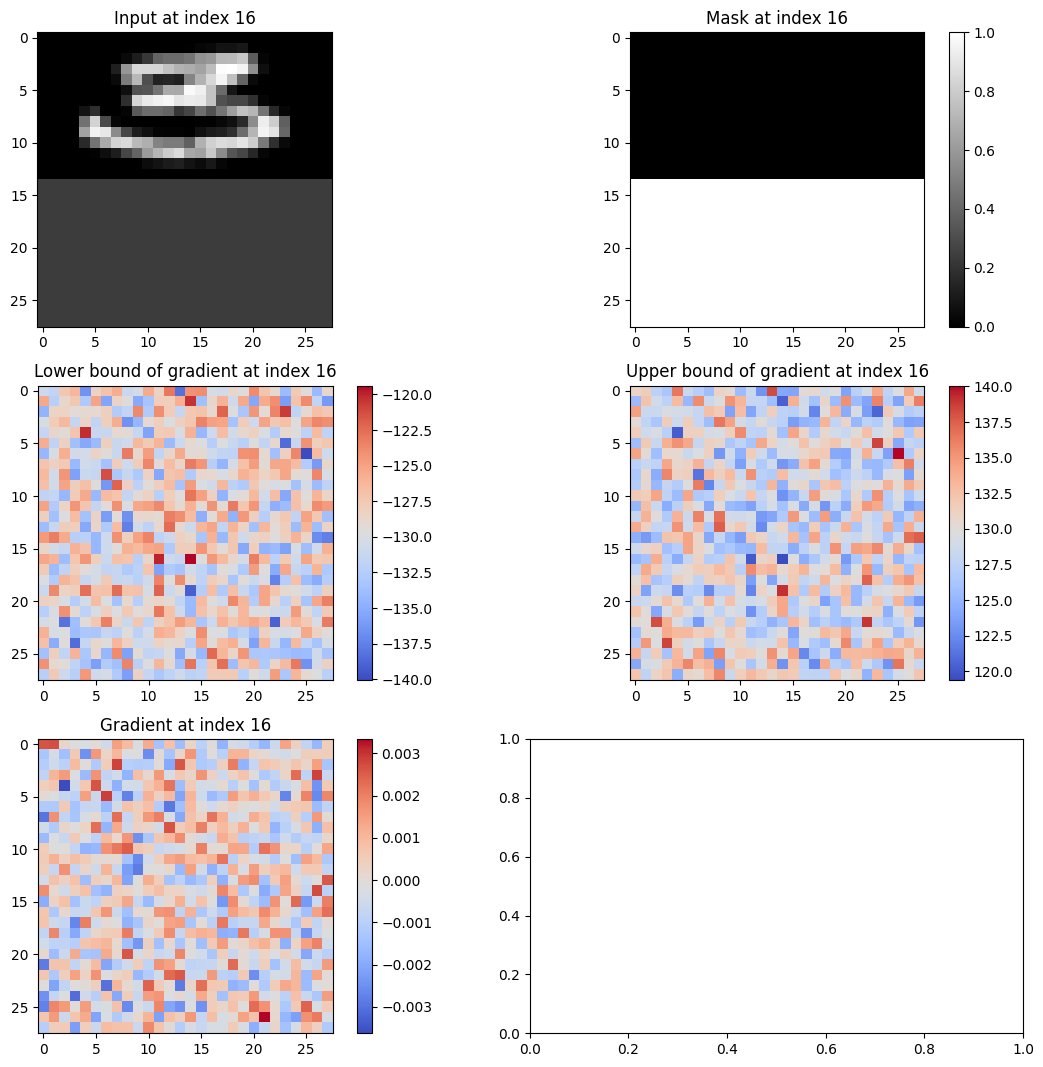

In [5]:
elem_idx = torch.randint(0, train_batch_size, (1,)).item()
print(elem_idx)
train_batch = list(next(iter(dl_masks_train)))
print(train_batch[0][elem_idx][0][0])
print(train_batch[0][elem_idx][27][27])
visualize_gradient(model, train_batch[0], train_batch[1], train_batch[2], 0.1, elem_idx)

## Experiments 

In [6]:
DELTA_INPUT_ROBUSTNESS_PARAM = 0.5
model_root_save_dir = "saved_experiment_models/performance/half_decoy_mnist/"
os.makedirs(model_root_save_dir, exist_ok=True)
# r4_pmo is the same as r4 but with only the masked region perturbed
methods = ["std", "r3", "r4", "ibp_ex", "ibp_ex+r3", "pgd_r4", "rand_r4", "smooth_r3"]
save_dir_for_method = {method: os.path.join(model_root_save_dir, method) for method in methods}
for method in methods:
    os.makedirs(save_dir_for_method[method], exist_ok=True)

### Standard Training

In [ ]:
std_method = "std"
# hyperparameters
num_epochs, lr, restarts, epsilon, weight_coeff, k, weight_decay = 40, 0.0001, 3, 0.1, -1, -1, 1e-4
# Train standard 3 times and test accuracy and delta input robustness for the masked region
train_acc, test_acc, num_robust, avg_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 0, 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = FCNAugmented(*ARCH)

    print(f"========== Training model with method {std_method} restart {i} ==========")
    train_model_with_certified_input_grad(dl_masks_train, num_epochs, curr_model, lr, criterion, epsilon, std_method, k, device, False, weight_decay=weight_decay)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_masks_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_masks_test, device, multi_class=True)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_masks_test, curr_model, epsilon, DELTA_INPUT_ROBUSTNESS_PARAM, "cross_entropy", device)
    num_robust += num_robust
    avg_delta += min_delta
    min_lower_bound += m_l
    max_upper_bound += m_u
    avg_g_acc, wg_acc, wg = test_model_avg_and_wg_accuracy(curr_model, dl_masks_test, device, num_groups=10, multi_class=True)
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[std_method], f"run_{i}.pt"))
empty_model = FCNAugmented(*ARCH)
avg_acc, wg_acc, wg, *_ = get_restart_avg_and_worst_group_accuracy_with_stddev(
    dl_masks_test, save_dir_for_method[std_method], empty_model, device, num_groups=10, multi_class=True
)
write_results_to_file("experiment_results/half_decoy_mnist.yaml",
                      {"train_acc": round(train_acc / restarts, 5),
                       "test_acc": round(test_acc / restarts, 5),
                       "avg_group_acc": round(avg_acc, 5),
                       "worst_group_acc": round(wg_acc, 5),
                       "worst_group": wg,
                       "min_robust_delta": round(avg_delta / restarts, 5),
                       "min_lower_bound": round(min_lower_bound / restarts, 5),
                       "max_upper_bound": round(max_upper_bound / restarts, 5)
                       }, std_method)
write_results_to_file("experiment_results/half_decoy_mnist_params.yaml",
                        {"epsilon": epsilon,
                         "test_epsilon": epsilon,
                         "k": k,
                         "weight_coeff": weight_coeff,
                         "num_epochs": num_epochs,
                         "lr": lr,
                         "restarts": restarts,
                         "train_batch_size": dl_masks_train.batch_size,
                         "test_batch_size": dl_masks_test.batch_size,
                         "class_weights": -1,
                         "multi_class": True,
                         "has_conv": False,
                         "weight_decay": weight_decay,
                         "with_k_schedule": False}, std_method)

### RRR Training

In [12]:
rrr_method = "r3"
# rebatch
train_batch_size = 256
dl_masks_train = torch.utils.data.DataLoader(dl_masks_train.dataset, batch_size=train_batch_size, shuffle=True)
# hyperparams
num_epochs, lr, restarts, epsilon, k, weight_decay = 40, 0.0001, 4, 0.1, 100, 3e-4
train_acc, test_acc, num_robust, avg_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 0, 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = FCNAugmented(*ARCH)

    print(f"========== Training model with method {rrr_method}, restart {i} ==========")
    train_model_with_certified_input_grad(dl_masks_train, num_epochs, curr_model, lr, criterion, epsilon, rrr_method,
        k, device, False, weight_decay=weight_decay)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_masks_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_masks_test, device, multi_class=True)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_masks_test, curr_model, epsilon, DELTA_INPUT_ROBUSTNESS_PARAM, "cross_entropy", device)
    num_robust += num_robust
    avg_delta += min_delta
    min_lower_bound += m_l
    max_upper_bound += m_u
    avg_g_acc, wg_acc, wg = test_model_avg_and_wg_accuracy(curr_model, dl_masks_test, device, num_groups=10, multi_class=True)
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[rrr_method], f"run_{i}.pt"))
empty_model = FCNAugmented(*ARCH)
avg_acc, wg_acc, wg, *_ = get_restart_avg_and_worst_group_accuracy_with_stddev(
    dl_masks_test, save_dir_for_method[rrr_method], empty_model, device, num_groups=10, multi_class=True
)
write_results_to_file("experiment_results/half_decoy_mnist.yaml",
                      {"train_acc": round(train_acc / restarts, 5),
                       "test_acc": round(test_acc / restarts, 5),
                       "avg_group_acc": round(avg_acc, 5),
                       "worst_group_acc": round(wg_acc, 5),
                       "worst_group": wg,
                       "min_robust_delta": round(avg_delta / restarts, 5),
                       "min_lower_bound": round(min_lower_bound / restarts, 5),
                       "max_upper_bound": round(max_upper_bound / restarts, 5)
                       }, rrr_method)
write_results_to_file("experiment_results/half_decoy_mnist_params.yaml",
                        {"epsilon": epsilon,
                         "test_epsilon": epsilon,
                         "k": k,
                         "weight_coeff": weight_coeff,
                         "num_epochs": num_epochs,
                         "lr": lr,
                         "restarts": restarts,
                         "train_batch_size": dl_masks_train.batch_size,
                         "test_batch_size": dl_masks_test.batch_size,
                         "class_weights": -1,
                         "multi_class": True,
                         "weight_decay": weight_decay,
                         "has_conv": False,
                         "with_k_schedule": False}, rrr_method)

========== Training model with method r3, restart 0 ==========


Epoch: 100%|██████████| 40/40 [02:51<00:00,  4.29s/it, loss=1.48, reg=tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)]    


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.9993
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.2303


KeyboardInterrupt: 

### R4 Training

In [14]:
# Train standard 3 times and test accuracy and delta input robustness for the masked region
r4_method = "r4"
num_epochs, lr, restarts, epsilon, k = 35, 0.0003, 4, 1, 0.2
test_epsilon = 0.1
train_acc, test_acc, num_robust, avg_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 0, 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = FCNAugmented(*ARCH)

    print(f"========== Training model with method R4, restart {i} ==========")
    train_model_with_certified_input_grad(dl_masks_train, num_epochs, curr_model, lr, criterion, epsilon, r4_method, k,
        device, False)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_masks_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_masks_test, device, multi_class=True)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_masks_test, curr_model, test_epsilon, DELTA_INPUT_ROBUSTNESS_PARAM, "cross_entropy", device)
    num_robust += n_r
    avg_delta += min_delta
    min_lower_bound += m_l
    max_upper_bound += m_u
    avg_g_acc, wg_acc, wg = test_model_avg_and_wg_accuracy(curr_model, dl_masks_test, device, num_groups=10, multi_class=True)
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[r4_method], f"run_{i}.pt"))
empty_model = FCNAugmented(*ARCH)
avg_acc, wg_acc, wg, *_ = get_restart_avg_and_worst_group_accuracy_with_stddev(
    dl_masks_test, save_dir_for_method[r4_method], empty_model, device, num_groups=10, multi_class=True
)
write_results_to_file("experiment_results/decoy_mnist.yaml",
                      {"train_acc": round(train_acc / restarts, 5),
                       "test_acc": round(test_acc / restarts, 5),
                       "avg_group_acc": round(avg_acc, 5),
                       "worst_group_acc": round(wg_acc, 5),
                       "worst_group": wg,
                       "min_robust_delta": round(avg_delta / restarts, 5),
                       "min_lower_bound": round(min_lower_bound / restarts, 5),
                       "max_upper_bound": round(max_upper_bound / restarts, 5)
                       }, r4_method)
write_results_to_file("experiment_results/decoy_mnist_params.yaml",
                        {"epsilon": epsilon,
                         "test_epsilon": test_epsilon,
                         "k": k,
                         "weight_coeff": weight_coeff,
                         "num_epochs": num_epochs,
                         "lr": lr,
                         "restarts": restarts,
                         "train_batch_size": dl_masks_train.batch_size,
                         "test_batch_size": dl_masks_test.batch_size,
                         "class_weights": -1,
                         "multi_class": True,
                         "has_conv": False,
                         "weight_decay": weight_decay,
                         "with_k_schedule": False}, r4_method)

========== Training model with method R4, restart 0 ==========


Epoch: 100%|██████████| 35/35 [03:13<00:00,  5.53s/it, loss=2.3, reg=tensor(1.9873e-07, device='cuda:0', grad_fn=<DivBackward0>)] 


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.1124
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.1135
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 0
--- Model accuracy per group ---
Macro average group accuracy = 0.1
Min group accuracy = 0, group idx = 0
========== Training model with method R4, restart 1 ==========


Epoch:   0%|          | 0/35 [00:00<?, ?it/s, loss=28.1, reg=tensor(128.9354, device='cuda:0', grad_fn=<DivBackward0>)]


KeyboardInterrupt: 

### IBP-EX Training

In [ ]:
ibp_ex_method = "ibp_ex"
# Train standard 3 times and test accuracy and delta input robustness for the masked region
num_epochs, lr, restarts, epsilon, weight_coeff, k = 30, 0.075, 4, 0.25, 0.0002, 4
test_epsilon = 0.1
train_acc, test_acc, num_robust, avg_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 0, 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = FCNAugmented(*ARCH)

    print(f"========== Training model with method {ibp_ex_method} restart {i} ==========")
    train_model_with_certified_input_grad(dl_masks_train, num_epochs, curr_model, lr, criterion, epsilon, ibp_ex_method, k,
                                          device, False, weight_reg_coeff=weight_coeff)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_masks_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_masks_test, device, multi_class=True)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_masks_test, curr_model, test_epsilon, DELTA_INPUT_ROBUSTNESS_PARAM, "cross_entropy", device)
    num_robust += n_r
    avg_delta += min_delta
    min_lower_bound += m_l
    max_upper_bound += m_u
    avg_g_acc, wg_acc, wg = test_model_avg_and_wg_accuracy(curr_model, dl_masks_test, device, num_groups=10, multi_class=True)
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[ibp_ex_method], f"run_{i}.pt"))
empty_model = FCNAugmented(*ARCH)
avg_acc, wg_acc, wg, *_ = get_restart_avg_and_worst_group_accuracy_with_stddev(
    dl_masks_test, save_dir_for_method[ibp_ex_method], empty_model, device, num_groups=10, multi_class=True
)
write_results_to_file("experiment_results/decoy_mnist.yaml",
                      {"train_acc": round(train_acc / restarts, 5),
                       "test_acc": round(test_acc / restarts, 5),
                       "avg_group_acc": round(avg_acc, 5),
                       "worst_group_acc": round(wg_acc, 5),
                       "worst_group": wg,
                       "min_robust_delta": round(avg_delta / restarts, 5),
                       "min_lower_bound": round(min_lower_bound / restarts, 5),
                       "max_upper_bound": round(max_upper_bound / restarts, 5)
                       }, ibp_ex_method)
write_results_to_file("experiment_results/decoy_mnist_params.yaml",
                        {"epsilon": epsilon,
                         "test_epsilon": test_epsilon,
                         "k": k,
                         "weight_coeff": weight_coeff,
                         "num_epochs": num_epochs,
                         "lr": lr,
                         "restarts": restarts,
                         "train_batch_size": dl_masks_train.batch_size,
                         "test_batch_size": dl_masks_test.batch_size,
                         "class_weights": -1,
                         "multi_class": True,
                         "has_conv": False,
                         "with_k_schedule": False}, ibp_ex_method)

### IBP-EX + R3 Training

In [ ]:
ibp_ex_and_r3_method = "ibp_ex+r3"
# Train standard 3 times and test accuracy and delta input robustness for the masked region
num_epochs, lr, restarts, epsilon, weight_coeff, k = 30, 0.01, 4, 0.15, 0.0006, 2.1
test_epsilon = 0.1
train_acc, test_acc, num_robust, avg_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 0, 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = FCNAugmented(*ARCH)

    print(f"========== Training model with method {ibp_ex_and_r3_method} restart {i} ==========")
    train_model_with_certified_input_grad(dl_masks_train, num_epochs, curr_model, lr, criterion, epsilon, ibp_ex_and_r3_method, k,
                                          device, False, weight_reg_coeff=weight_coeff)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_masks_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_masks_test, device, multi_class=True)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_masks_test, curr_model, test_epsilon, DELTA_INPUT_ROBUSTNESS_PARAM, "cross_entropy", device)
    num_robust += n_r
    avg_delta += min_delta
    min_lower_bound += m_l
    max_upper_bound += m_u
    avg_g_acc, wg_acc, wg = test_model_avg_and_wg_accuracy(curr_model, dl_masks_test, device, num_groups=10, multi_class=True)
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[ibp_ex_and_r3_method], f"run_{i}.pt"))
empty_model = FCNAugmented(*ARCH)
avg_acc, wg_acc, wg, *_ = get_restart_avg_and_worst_group_accuracy_with_stddev(
    dl_masks_test, save_dir_for_method[ibp_ex_and_r3_method], empty_model, device, num_groups=10, multi_class=True
)
write_results_to_file("experiment_results/decoy_mnist.yaml",
                      {"train_acc": round(train_acc / restarts, 5),
                       "test_acc": round(test_acc / restarts, 5),
                       "avg_group_acc": round(avg_acc, 5),
                       "worst_group_acc": round(wg_acc, 5),
                       "worst_group": wg,
                       "min_robust_delta": round(avg_delta / restarts, 5),
                       "min_lower_bound": round(min_lower_bound / restarts, 5),
                       "max_upper_bound": round(max_upper_bound / restarts, 5)
                       }, ibp_ex_and_r3_method)
write_results_to_file("experiment_results/decoy_mnist_params.yaml",
                        {"epsilon": epsilon,
                         "test_epsilon": test_epsilon,
                         "k": k,
                         "weight_coeff": weight_coeff,
                         "num_epochs": num_epochs,
                         "lr": lr,
                         "restarts": restarts,
                         "train_batch_size": dl_masks_train.batch_size,
                         "test_batch_size": dl_masks_test.batch_size,
                         "class_weights": -1,
                         "multi_class": True,
                         "has_conv": False,
                         "with_k_schedule": False}, ibp_ex_and_r3_method)

# PGD-R4

In [ ]:
pgd_r4 = "pgd_r4"
# Train standard 3 times and test accuracy and delta input robustness for the masked region
num_epochs, lr, restarts, epsilon, weight_coeff, k = 30, 0.001, 4, 0.5, 0.0001, 14
test_epsilon = 0.1
train_acc, test_acc, num_robust, avg_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 0, 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = FCNAugmented(*ARCH)

    print(f"========== Training model with method {pgd_r4} restart {i} ==========")
    train_model_with_pgd_robust_input_grad(
        dl_masks_train, num_epochs, curr_model, lr, criterion, epsilon, pgd_r4, k, device, weight_reg_coeff=weight_coeff
    )
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_masks_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_masks_test, device, multi_class=True)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_masks_test, curr_model, test_epsilon, DELTA_INPUT_ROBUSTNESS_PARAM, "cross_entropy", device)
    num_robust += n_r
    avg_delta += min_delta
    min_lower_bound += m_l
    max_upper_bound += m_u
    avg_g_acc, wg_acc, wg = test_model_avg_and_wg_accuracy(curr_model, dl_masks_test, device, num_groups=10, multi_class=True)
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[pgd_r4], f"run_{i}.pt"))
empty_model = FCNAugmented(*ARCH)
avg_acc, wg_acc, wg, *_ = get_restart_avg_and_worst_group_accuracy_with_stddev(
    dl_masks_test, save_dir_for_method[pgd_r4], empty_model, device, num_groups=10, multi_class=True
)
write_results_to_file("experiment_results/decoy_mnist.yaml",
                      {"train_acc": round(train_acc / restarts, 5),
                       "test_acc": round(test_acc / restarts, 5),
                       "avg_group_acc": round(avg_acc, 5),
                       "worst_group_acc": round(wg_acc, 5),
                       "worst_group": wg,
                       "min_robust_delta": round(avg_delta / restarts, 5),
                       "min_lower_bound": round(min_lower_bound / restarts, 5),
                       "max_upper_bound": round(max_upper_bound / restarts, 5)
                       }, pgd_r4)
write_results_to_file("experiment_results/decoy_mnist_params.yaml",
                        {"epsilon": epsilon,
                         "test_epsilon": test_epsilon,
                         "k": k,
                         "weight_coeff": weight_coeff,
                         "num_epochs": num_epochs,
                         "lr": lr,
                         "restarts": restarts,
                         "train_batch_size": dl_masks_train.batch_size,
                         "test_batch_size": dl_masks_test.batch_size,
                         "class_weights": -1,
                         "multi_class": True,
                         "has_conv": False,
                         "with_k_schedule": False}, pgd_r4)

# Smoothed-R3

In [ ]:
smooth_r3 = "smooth_r3"
# Train standard 3 times and test accuracy and delta input robustness for the masked region
num_epochs, lr, restarts, epsilon, weight_coeff, k = 25, 0.001, 4, 0.1, 0.0001, 10
test_epsilon = 0.1
train_acc, test_acc, num_robust, avg_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 0, 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = FCNAugmented(*ARCH)

    print(f"========== Training model with method {smooth_r3} restart {i} ==========")
    train_model_with_smoothed_input_grad(
        dl_masks_train, num_epochs, curr_model, lr, criterion, epsilon, smooth_r3, k, device, weight_reg_coeff=weight_coeff
    )
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_masks_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_masks_test, device, multi_class=True)
    _, min_delta, m_l, m_u = test_delta_input_robustness(dl_masks_test, curr_model, test_epsilon, DELTA_INPUT_ROBUSTNESS_PARAM, "cross_entropy", device)
    avg_delta += min_delta
    min_lower_bound += m_l
    max_upper_bound += m_u
    avg_g_acc, wg_acc, wg = test_model_avg_and_wg_accuracy(curr_model, dl_masks_test, device, num_groups=10, multi_class=True)
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[smooth_r3], f"run_{i}.pt"))
empty_model = FCNAugmented(*ARCH)
avg_acc, wg_acc, wg, *_ = get_restart_avg_and_worst_group_accuracy_with_stddev(
    dl_masks_test, save_dir_for_method[smooth_r3], empty_model, device, num_groups=10, multi_class=True
)
write_results_to_file("experiment_results/decoy_mnist.yaml",
                      {"train_acc": round(train_acc / restarts, 5),
                       "test_acc": round(test_acc / restarts, 5),
                       "avg_group_acc": round(avg_acc, 5),
                       "worst_group_acc": round(wg_acc, 5),
                       "worst_group": wg,
                       "min_robust_delta": round(avg_delta / restarts, 5),
                       "min_lower_bound": round(min_lower_bound / restarts, 5),
                       "max_upper_bound": round(max_upper_bound / restarts, 5)
                       }, smooth_r3)
write_results_to_file("experiment_results/decoy_mnist_params.yaml",
                        {"epsilon": epsilon,
                         "test_epsilon": test_epsilon,
                         "k": k,
                         "weight_coeff": weight_coeff,
                         "num_epochs": num_epochs,
                         "lr": lr,
                         "restarts": restarts,
                         "train_batch_size": dl_masks_train.batch_size,
                         "test_batch_size": dl_masks_test.batch_size,
                         "class_weights": -1,
                         "multi_class": True,
                         "has_conv": False,
                         "with_k_schedule": False}, smooth_r3)

# Rand-R4

In [ ]:
rand_r4 = "rand_r4"
# Train standard 3 times and test accuracy and delta input robustness for the masked region
num_epochs, lr, restarts, epsilon, weight_coeff, k = 30, 0.001, 4, 0.5, 0.0001, 15
test_epsilon = 0.1
train_acc, test_acc, num_robust, avg_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 0, 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = FCNAugmented(*ARCH)

    print(f"========== Training model with method {rand_r4} restart {i} ==========")
    train_model_with_smoothed_input_grad(
        dl_masks_train, num_epochs, curr_model, lr, criterion, epsilon, rand_r4, k, device, weight_reg_coeff=weight_coeff
    )
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_masks_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_masks_test, device, multi_class=True)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_masks_test, curr_model, test_epsilon, DELTA_INPUT_ROBUSTNESS_PARAM, "cross_entropy", device)
    num_robust += n_r
    avg_delta += min_delta
    min_lower_bound += m_l
    max_upper_bound += m_u
    avg_g_acc, wg_acc, wg = test_model_avg_and_wg_accuracy(curr_model, dl_masks_test, device, num_groups=10, multi_class=True)
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[rand_r4], f"run_{i}.pt"))
empty_model = FCNAugmented(*ARCH)
avg_acc, wg_acc, wg, *_ = get_restart_avg_and_worst_group_accuracy_with_stddev(
    dl_masks_test, save_dir_for_method[rand_r4], empty_model, device, num_groups=10, multi_class=True
)
write_results_to_file("experiment_results/decoy_mnist.yaml",
                      {"train_acc": round(train_acc / restarts, 5),
                       "test_acc": round(test_acc / restarts, 5),
                       "avg_group_acc": round(avg_acc, 5),
                       "worst_group_acc": round(wg_acc, 5),
                       "worst_group": wg,
                       "min_robust_delta": round(avg_delta / restarts, 5),
                       "min_lower_bound": round(min_lower_bound / restarts, 5),
                       "max_upper_bound": round(max_upper_bound / restarts, 5)
                       }, rand_r4)
write_results_to_file("experiment_results/decoy_mnist_params.yaml",
                        {"epsilon": epsilon,
                         "test_epsilon": test_epsilon,
                         "k": k,
                         "weight_coeff": weight_coeff,
                         "num_epochs": num_epochs,
                         "lr": lr,
                         "restarts": restarts,
                         "train_batch_size": dl_masks_train.batch_size,
                         "test_batch_size": dl_masks_test.batch_size,
                         "class_weights": -1,
                         "multi_class": True,
                         "has_conv": False,
                         "with_k_schedule": False}, rand_r4)